## 3. Lattice Gauge Theory

Now we learn how to simulate the dynamics of a Lattice Gauge Theory (LGT) with a 1D Rydberg atom chain. In the realm of gauge theories, it has been discovered that the Z2 ground state and the quantum scar of the Rydberg chain correspond to the 'string' state and the string-inversion mechanism of the studied LGT, respectively. More intriguingly, by selectively addressing certain atoms, we can induce defects in the chain and simulate the propagation of particle-antiparticle pairs. This tutorial is inspired by the paper by F. M. Surace et al. (DOI: 10.1103/PhysRevX.10.021041).



We will introduce a new feature in order to accomplish this LGT simulation. To simulate the dynamics of the particle excitation, we need to be able to "selectively address" certain atoms for the initial state. This is accomplished via Local Detuning where we are able to control how much of the global detuning is applied to each atom through a multiplicative scaling factor.



### 3a. Mapping Rydberg system to a lattice gauge theory

As we learned before, the Rydberg Hamiltonian can be written as: 

\begin{align}
\frac{\mathcal{H}(t)}{\hbar} = & \sum_i \Omega X_{i}  + \sum_{i \neq j} V_{i,j} \hat{n}_i \hat{n}_{j} \\
 & - \sum_i \Delta \hat{n}_{i}  \nonumber
\end{align}

If we focus on the regime of perfect blockade of nearest neighbour, the resulting Hamiltonian can be written as a PXP model: 
$$
H_{PXP} = \sum_{i=1}^N  \Omega   P_{i-1} X_{i}P_{i+1} -  \Delta n_{i}.
$$



We are interested in the so-called quantum link model (QLM) formulation
of the LGT. In this formalism, depending on the configurations of the even and odd sites,
the bonds between them could be interpreted as a particle $q$, an antiparticle $\bar{q}$
or a vacuum state. More specifically, the bond between an odd and an even sites corresponds
to an antiparticle if both atoms are in the ground states, otherwise it is interpreted as
a vacuum state. On the other hand, the bond between an even and an odd sites corresponds
to a particle if both atoms are in the ground states, otherwise it is interpreted as a vacuum. Further, the Rydberg states at the odd (even) sites are interpreted as electric fields pointing to the left (right), whereas the ground states at the odd (even) sites are electric field pointing to the right (left). The electric fields correspond to the red and blue arrows in the following figure, which summarizes the mappings described above (source: [F. M. Surace et al. (10.1103/PhysRevX.10.021041)](https://journals.aps.org/prx/pdf/10.1103/PhysRevX.10.021041)).


<img src="./assets/lgt_mapping.png" width="1000" height="auto" />


After this mapping, the blockade Rydberg state are the gauge-invariant sub-sector of the states for the generators
$$
G_{j} = E_{j, j+1} - E_{j-1, j} - \Phi_{j}^{\dagger} \Phi_{j} + \frac{1 - (-1)^{j}}{2}
$$
where $E_{j, j+1} = S_{j, j+1}^z$ for spin-1/2, and $\Phi_{j} $ is the matter field. 

### 3b. Preparing specific product states using local detuning

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt

from bloqade import save, load, cast, piecewise_linear
from bloqade.ir.location import Chain


from bokeh.io import output_notebook
output_notebook() # enable interactive plots in Jupyter

if not os.path.isdir("data"):
    os.mkdir("data")

Loading BokehJS ...

The local detuning field on the hardware can be expressed by the following 
$F_{i}(t) =  C_{i} f(t) $, where the $C_{i}$ is the scale for site $i$ that lies between 0 and 1, and $f(t)$ is the global time-dependent waveform that is universal for all sites. 

In the prgram, we create a list of values from 0 to 1 with length equal to the number of atoms in the system. A value of 1 means the atom should experience the full detuning waveform while 0 means the atom should not experience it at all.  The n-th value in the list corresponds to the n-th atom in the system.

The physical consequence of local detuning is that: if for certain sites the local detuning has a large value, the excitation of the Rydberg atom will cost a lot of energy. Therefore, the large value of local detuning will prevent the Rydberg excitation.  We can use such a feature to prepare initial states that is not regular as $Z_2$ states, but is still within the blockade constraint. 

Let us now try an example below to prepare a state that is different from $Z_2$, where a few atoms are de-excited by the local detuning field. 


In [2]:
N_atom = 13
# Setup the detuning scaling per atom.
# Note that the list of scaling values has a length equal to 
# the number of atoms
detuning_ratio = [0] * N_atom
detuning_ratio[1:(N_atom-1):2] = [1, 1, 1, 1, 1, 1]
detuning_ratio[(N_atom-1)//2] = 1
detuning_ratio[2] = 1
# Notice that the detuning ratio will allow us to prepare a Z2 
# ordered phase. However, the sequence of contiguous 1s in the 
# middle introduce a defect.
detuning_ratio

[0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0]

Now we build the waveforms to prepare the states with local detuning field, and global Rabi and detuning fields. 

In [4]:

# Define our waveforms first, then plug them into the 
# program structure below
rabi_amplitude_wf = piecewise_linear(durations=[0.1, 2.0, 0.05], values=[0, 5*np.pi, 5*np.pi, 4*np.pi])
uniform_detuning_wf = piecewise_linear(durations=[2.1, 0.05], values=[-6*np.pi, 8*np.pi, 0])
local_detuning_wf = piecewise_linear([0.1, 2.0, 0.05], values=[0, -8*2*np.pi, -8 *2*np.pi, 0])

# Note that `scale` is called right after defining the 
# global detuning
program = (
    Chain(N_atom, lattice_spacing=5.5, vertical_chain=True)
     .rydberg.rabi.amplitude.uniform.apply(rabi_amplitude_wf)
         .detuning.uniform.apply(uniform_detuning_wf)
                  .scale(detuning_ratio).apply(local_detuning_wf)
)



We now emulate the dynamics and see the results. We see that the state with the largest probability is indeed the product state we expected, where the sites with large local detuning is de-excited. 

In [8]:
emu_prog=program.bloqade.python().run(shots=100)
emu_prog.report().show()

### 3c. Lattice Gauge Theory Simulation


We use similar approach as we used above to prepare a state where the central site
is de-excited on top of the ordenary $Z_2$ state.  After the preparation of the state, we turn off both the global and local detuning, and simulate the dynamics of the quasiparticle. 

In such case, the waveform is simular to the quantum scar example as we see before. First, we use certain waveform to prepare the state, and attached to that, we run the coherent dynamics for that initial state. We create the waveform below. 

In [10]:
N_atom = 13
# Setup the detuning scaling per atom.
# Note that the list of scaling values has a length equal to 
# the number of atoms
detuning_ratio = [0] * N_atom
detuning_ratio[1:(N_atom-1):2] = [1, 1, 1, 1, 1, 1]
detuning_ratio[(N_atom-1)//2] = 1
# Notice that the detuning ratio will allow us to prepare a Z2 
# ordered phase. However, the sequence of contiguous 1s in the 
# middle introduce a defect.
detuning_ratio

run_time = cast("run_time")

# Define our waveforms first, then plug them into the 
# program structure below
rabi_amplitude_wf = piecewise_linear(durations=[0.1, 2.0, 0.05, run_time, 0.05], values=[0, 5*np.pi, 5*np.pi, 4*np.pi, 4*np.pi, 0])
uniform_detuning_wf = piecewise_linear(durations=[2.1, 0.05, run_time+0.05], values=[-6*np.pi, 8*np.pi, 0, 0])
local_detuning_wf = piecewise_linear([0.1, 2.0, 0.05, run_time+0.05], values=[0, -8*2*np.pi, -8 *2*np.pi, 0, 0])

# Note that `scale` is called right after defining the 
# global detuning
program = (
    Chain(N_atom, lattice_spacing=5.5, vertical_chain=True)
     .rydberg.rabi.amplitude.uniform.apply(rabi_amplitude_wf)
         .detuning.uniform.apply(uniform_detuning_wf)
                  .scale(detuning_ratio).apply(local_detuning_wf)
)

run_times = np.arange(0.0, 1.05, 0.05)
batch = program.batch_assign(run_time = run_times)

We now run the program on both the emulator.

In [11]:
emu_batch = batch.bloqade.python().run(1000, rtol=1e-10)

The following code plots the Rydberg onsite density from emulation as a function of evolution time after preparing the initial state with a defect in the middle. We observe that this defect propagates ballistically to the boundary and bounces back and forth.

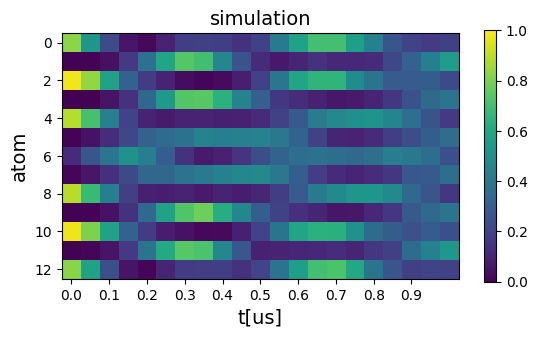

In [12]:
emu_report = emu_batch.report()
emu_rydberg_densities = emu_report.rydberg_densities()

plt.imshow(np.array(emu_rydberg_densities).T, vmin=0, vmax=1)
plt.xticks(ticks=np.arange(0,20, 2), labels=np.round(np.arange(0.,1.0, 0.1), 1), minor=False)
plt.xlabel("t[us]", fontsize=14)
plt.ylabel("atom", fontsize=14)
plt.title("simulation", fontsize=14)
plt.colorbar(shrink=0.68)
plt.show()

Additionally, we can plot the correlation between nearest-neighbor sites to illustrate the propagation of the defect across the chain.

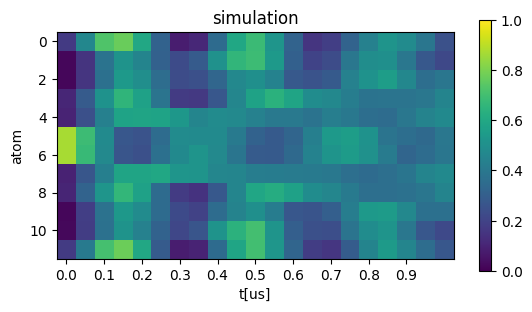

In [13]:
def rydberg_correlation(task_bits: np.ndarray, i: int, j: int) -> np.ndarray:
    return np.mean(task_bits[:,i]*task_bits[:,j])

emu_bitstrings = emu_report.bitstrings()
bits = np.array(emu_bitstrings)
num_tasks = len(bits)
corrs= np.zeros((num_tasks, N_atom-1), dtype=np.float64)
for task_index, task_bits in enumerate(bits):
    for i in range(N_atom-1):
        corrs[task_index, i] = rydberg_correlation(task_bits, i, i+1)

plt.imshow(corrs.T, vmin=0, vmax=1)
plt.xticks(ticks=np.arange(0,20, 2), labels=np.round(np.arange(0.,1.0, 0.1), 1), minor=False)
plt.xlabel("t[us]")
plt.ylabel("atom")
plt.title("simulation")
plt.colorbar(shrink=0.68)
plt.show()